## INT2 Project

In [6]:
"""from google.colab import drive
drive.mount('/content/gdrive')

root_path = '/content/drive/MyDrive/Uni/int2/'  #change dir to your project folder

from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kagglen
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

#!kaggle datasets list 
#!kaggle datasets download -d oxcdcd/cifar10 -p /content/gdrive/MyDrive/kaggle/cifar10
#!kaggle datasets list -s CIFAR10  datasets/oxcdcd/cifar10"""
#!unzip -q /content/gdrive/MyDrive/kaggle/cifar10/cifar10.zip -d /content/gdrive/MyDrive/

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
import time

In [2]:
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/cifar10/train"
TEST_DATA_PATH = "/content/gdrive/MyDrive/cifar10/test"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

FileNotFoundError: ignored

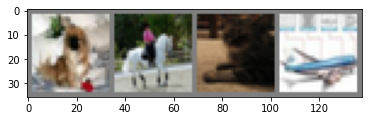

dog   horse cat   plane


In [8]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgGrid = torchvision.utils.make_grid(images)
imshow(imgGrid)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
writer = SummaryWriter("runs/Attempt1") #good one?
#tensorboard --logdir runs/testValidationError
writer.add_image("four images", imgGrid)
writer.flush()

In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [14]:
class Net(nn.Module):
    def __init__(self, resblock, in_channels=3, outputs=10):
        super().__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(256, 10)
        self.fc1 = nn.Linear(32768, 10)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

net = Net(ResBlock)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
print(len(testloader))
print(len(trainloader))
start_time = time.time()
for epoch in range(19):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f} time: {time.time() - start_time}')
            # Check against the validation set
            running_vloss = 0.0

            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(testloader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(trainloader) + i)
            running_loss = 0.0
    print(f'epoch time: {time.time() - start_time}')

print('Finished Training')

writer.flush()

2500
12500
[1,  1000] loss: 1.190 time: 57.639238119125366
[1,  2000] loss: 1.196 time: 166.59396600723267
[1,  3000] loss: 1.150 time: 286.2947573661804
[1,  4000] loss: 1.150 time: 395.7208733558655
[1,  5000] loss: 1.170 time: 505.30768060684204
[1,  6000] loss: 1.139 time: 614.1290073394775
[1,  7000] loss: 1.099 time: 723.3403148651123
[1,  8000] loss: 1.070 time: 832.474672794342
[1,  9000] loss: 1.104 time: 941.6649205684662
[1, 10000] loss: 1.066 time: 1051.2084214687347
[1, 11000] loss: 1.075 time: 1160.7897202968597
[1, 12000] loss: 1.025 time: 1269.5774760246277
epoch time: 1350.1481866836548
[2,  1000] loss: 0.943 time: 1405.4924507141113
[2,  2000] loss: 0.938 time: 1513.615665435791
[2,  3000] loss: 0.936 time: 1622.2711629867554
[2,  4000] loss: 0.938 time: 1730.6082820892334
[2,  5000] loss: 0.944 time: 1839.0210835933685
[2,  6000] loss: 0.903 time: 1947.5530264377594
[2,  7000] loss: 0.924 time: 2056.3996772766113
[2,  8000] loss: 0.899 time: 2165.0731630325317
[2,  9

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')